# Time Series Forecasting with ARIMA Models In Python [Part 1]
## A practical guide for time series forecasting using ARIMA models in Python

Time series data is one of the most common data types in the industry and you will probably be working with it in your career. Therefore understanding how to work with it and how to apply analytical and forecasting techniques are critical for every aspiring data scientist. In this series of notebooks, I will go through the basic techniques to work with time-series data, starting from data manipulation, analysis, and visualization to understand your data and prepare it for and then using the statistical, machine, and deep learning techniques for forecasting and classification. It will be more of a practical guide in which I will be applying each discussed and explained concept to real data.

Have you ever tried to predict the future? What lies ahead is a mystery that is usually only solved by waiting. In this notebook and the coming one, we will stop waiting and learn to use the powerful ARIMA class models to forecast the future. You will learn how to use the statsmodels package to analyze time series, build tailored models, and forecasting under uncertainty. How will the stock market move in the next 24 hours? How will the levels of CO2 change in the next decade? How many earthquakes will there be next year? You will learn to solve all these problems and more.

## Table of contents:

1. Introduction to ARMA Models

    1.1. Introduction to stationarity

    1.2. Making a time series stationary

    1.3. Introduction to AR, MA, and ARMA models

2. Fitting the Future

    2.1. Fitting time series models

    2.2. Forecasting

    2.3. ARIMA models for non-stationary time series

# 1. ARMA Models
We will start with a small introduction to stationarity and how this is important for ARMA models. Then we will revise how to test for stationarity by eye and with a standard statistical test. If you would like to get more information about these topics, you can check my previous article Time Series Analysis In Python as they are covered in more detail in it. Finally, you’ll learn the basic structure of ARMA models and use this to generate some ARMA data and fit an ARMA model.

We will use the candy production dataset, which represents the monthly candy production in the US between 1972 and 2018. Specifically, we will be using the industrial production index IPG3113N. This is the total amount of sugar and confectionery products produced in the USA per month, as a percentage of the January 2012 production. So 120 would be 120% of the January 2012 industrial production.

## 1.1. Introduction to stationarity
Stationary means that the distribution of the data doesn’t change with time. For a time series to be stationary it must fulfill three criteria:

The series has zero trends. It isn’t growing or shrinking.
The variance is constant. The average distance of the data points from the zero line isn’t changing.
The autocorrelation is constant. How each value in the time series is related to its neighbors stays the same.
The importance of stationarity comes from that to model a time series, it must be stationary. The reason for this is that modeling is all about estimating parameters that represent the data, therefore if the parameters of the data are changing with time, it will be difficult to estimate all the parameters.

Let’s first load and plot the monthly candy production dataset:

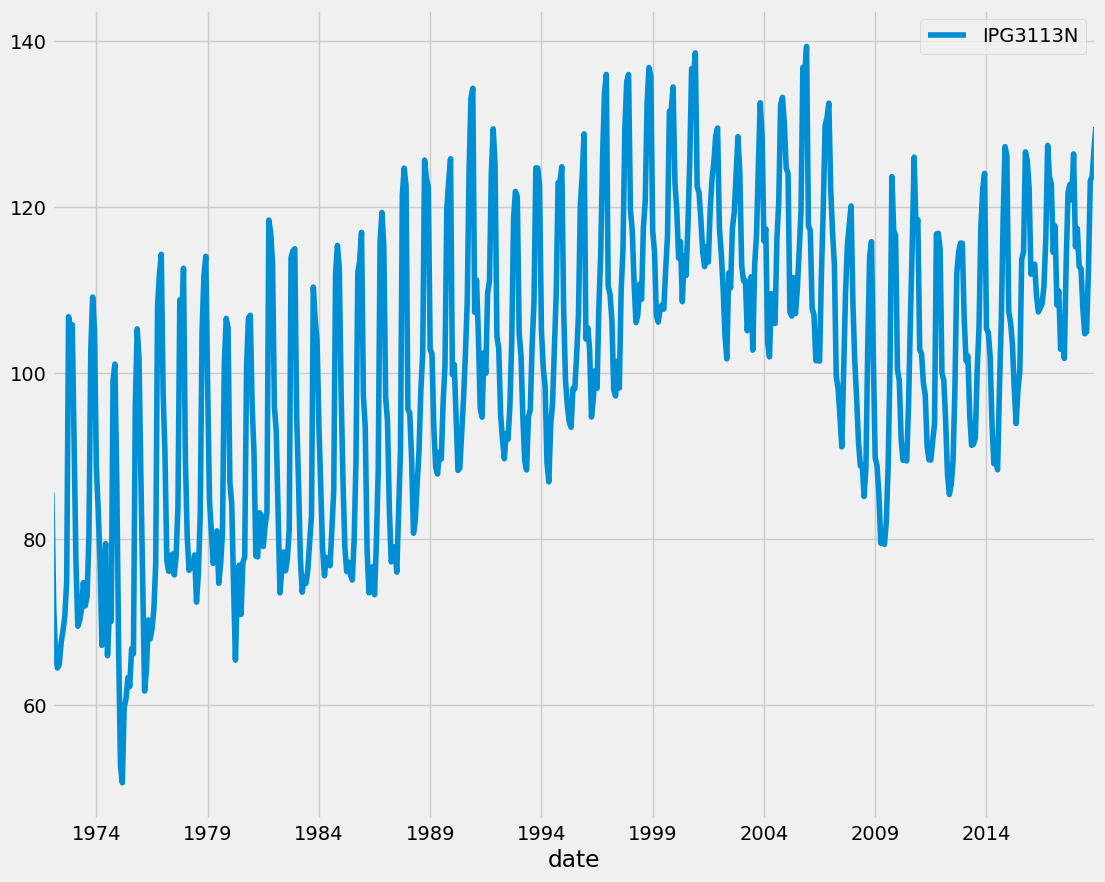

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# Load in the time series
candy = pd.read_csv('/kaggle/input/candy-production/candy_production.csv', 
            index_col='date',
            parse_dates=True)
# change the plot style into fivethirtyeight 
plt.style.use('fivethirtyeight')

# Plot and show the time series on axis ax1
fig, ax1 = plt.subplots()
candy.plot(ax=ax1, figsize=(12,10))
plt.show()

Generally, in machine learning, you have a training set on which you fit your model, and a test set, on which you will test your predictions against. Time series forecasting is just the same. Our train-test split will be different. We use the past values to make future predictions, and so we will need to split the data in time. We train on the data earlier in the time series and test on the data that comes later. We can split time series at a given date as shown below using the DataFrame’s **.loc** method.

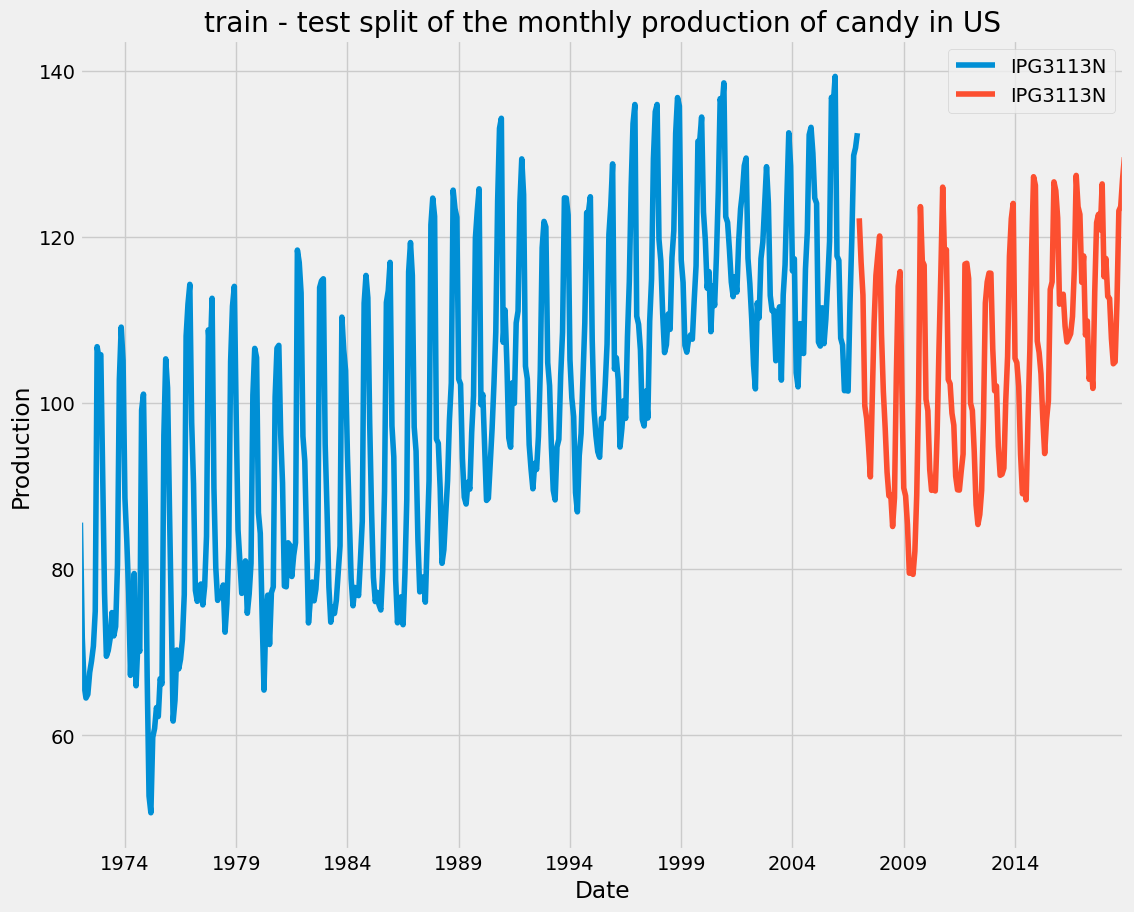

In [2]:
# Split the data into a train and test set
candy_train = candy.loc[:'2006']
candy_test = candy.loc['2007':]

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
candy_train.plot(ax=ax, figsize=(12,10))
candy_test.plot(ax=ax)
plt.title('train - test split of the monthly production of candy in US')
plt.xlabel('Date')
plt.ylabel('Production')
plt.show()


## 1.2. Making a time series stationary

There are many ways to test stationary, one of them with eyes, and others are more formal using statistical tests. There are also ways to transform non-stationary time series into stationary ones. We’ll address both of these in this subsection and then you’ll be ready to start modeling.

The most common test for identifying whether a time series is non-stationary is the augmented Dicky-Fuller test. This is a statistical test, where the null hypothesis is that your time series is non-stationary due to trends. We can implement the augmented Dicky-Fuller test using statsmodels. First, we import the adfuller function as shown, then we can run it on the candy production time series.

In [3]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(candy)
print(results)

(-1.7760153075016134, 0.3924327500713988, 14, 549, {'1%': -3.4423174665535385, '5%': -2.866818952732754, '10%': -2.569581505602171}, 3094.828881317046)


The results object is a tuple. The zeroth element is the test statistic, in this case, it is -1.77. The more negative this number is, the more likely that the data is stationary. The next item in the results tuple is the test p-value. Here it’s 0.3. If the p-value is smaller than 0.05, we reject the null hypothesis and assume our time series must be stationary. The last item in the tuple is a dictionary. This stores the critical values of the test statistic which equate to different p-values. In this case, if we wanted a p-value of 0.05 or below, our test statistic needed to be below -2.86.

Based on this result, we are sure that the time series is non-stationary. Therefore, we will need to transform the data into a stationary form before we can model it. We can think of this a bit like feature engineering in classic machine learning. One very common way to make a time series stationary is to take its difference. This is where from each value in our time series we subtract the previous value.

In [4]:
# Calculate the first difference and drop the nans
candy_diff = candy.diff()
candy_diff = candy_diff.dropna()

# Run test and print
result_diff = adfuller(candy_diff)
print(result_diff)

(-6.175912489755701, 6.631549159334048e-08, 13, 549, {'1%': -3.4423174665535385, '5%': -2.866818952732754, '10%': -2.569581505602171}, 3091.3123583091397)


From the results, we can see that now the time series are stationary. This time, taking the difference was enough to make it stationary, but for other time series, we may need to make the difference more than once or do other transformations. Sometimes we will need to perform other transformations to make the time series stationary. This could be to take the log, or the square root of a time series, or to calculate the proportional change. It can be hard to decide which of these to do, but often the simplest solution is the best one.

## 1.3. Introduction to AR, MA and ARMA models

In an autoregressive (AR) model, we regress the values of the time series against previous values of this same time series. The equation for a simple AR model is shown below:

y(t) = a(1) * y(t-1) + ϵ(t)

The value of the time series at the time (t) is the value of the time series at the previous step multiplied with parameter a(1) added to a noise or shock term ϵ(t). The shock term is white noise, meaning each shock is random and not related to the other shocks in the series. a(1) is the autoregressive coefficient at lag one. Compare this to a simple linear regression where the dependent variable is y(t) and the independent variable is y(t-1). The coefficient a(1) is just the slope of the line and the shocks are the residuals of the line.

This is a first-order AR model. The order of the model is the number of time lags used. An order two AR model has two autoregressive coefficients and has two independent variables, the series at lag one and the series at lag two. More generally, we use p to mean the order of the AR model. This means we have p autoregressive coefficients and use p lags.

In a moving average (MA) model, we regress the values of the time series against the previous shock values of this same time series. The equation for a simple MA model is shown below:

y(t) = m(1)*ϵ(t-1) + ϵ(t)

The value of the time series y(t)is m(1) times the value of the shock at the previous step; plus a shocking term for the current time step. This is a first-order MA model. Again, the order of the model means how many time lags we use. An MA two model would include shocks from one and two steps ago. More generally, we use q to mean the order of the MA model.

An ARMA model is a combination of the AR and MA models. The time series is regressed on the previous values and the previous shock terms. This is an ARMA-one-one model. More generally we use ARMA(p,q) to define an ARMA model. The p tells us the order of the autoregressive part of the model and the q tells us the order of the moving average part.

y(t) = a (1)*y(t-1) + m(1)* ϵ(t-1) + ϵ(t)

Using the statsmodels package, we can both fit ARMA models and create ARMA data. Let’s take this ARMA-one-one model. Say we want to simulate data with these coefficients. First, we import the arma-generate-sample function. Then we make lists for the AR and MA coefficients. Note that both coefficient lists start with one. This is for the zero-lag term and we will always set this to one. We set the lag one AR coefficient as 0.5 and the MA coefficient as 0.2. We generate the data, passing in the coefficients, the number of data points to create, and the standard deviation of the shocks. Here, we actually pass in the negative of the AR coefficients we desire. This is a quirk we will need to remember.

In [5]:
from statsmodels.tsa.arima_process import arma_generate_sample
ar_coefs = [1, -0.5] 
ma_coefs = [1, 0.2]
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, scale=0.5)


The generated data can be represented with this equation:

y(t) = 0.5y(t−1) + 0.2* ϵ(t−1) + ϵ(t).

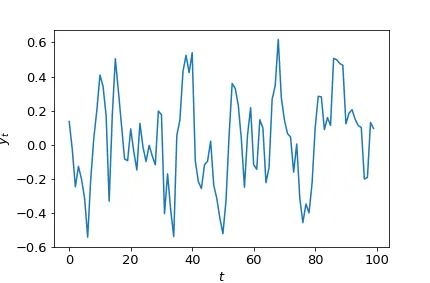

Fitting is covered in the next section, but here is a quick peek at how we might fit this data. First, we import the ARMA model class. We instantiate the model, feed it the data and define the model order. Then finally we fit.

In [6]:
from statsmodels.tsa.arima.model import ARIMA
# Instantiate model object
model = ARIMA(y, order=(1,0,1))
# Fit model
results = model.fit()


# 2. Fitting the Future
In this section, you’ll learn how to use the elegant statsmodels package to fit ARMA, ARIMA, and ARMAX models. Then you’ll use your models to predict the uncertain future of Amazon stock prices.

## 2.1. Fitting time series models

We had a quick look at fitting time series models in the last section but let’s have a closer look. To fit these models we first import the ARIMA model class from the statsmodels package. We create a model object and define the model order, we must also feed in the training data. The data can be a pandas dataframe, a pandas series, or a NumPy array. Remember that the order for an ARIMA model is (p,d,q) p is the autoregressive lags, d is the order of the difference, and q is the moving average lags. d is always an integer, while p and q may either be integers or lists of integers. To fit an AR model we can simply use the ARMA class with q equal to zero. To fit an MA model, we set p equal to zero.

Let’s have a look at the result summary of the fitted model :

In [7]:
from statsmodels.tsa.arima.model import ARIMA
# Instantiate model object
model = ARIMA(y, order=(1,0,1))
# Fit model
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -60.467
Date:                Sat, 02 Sep 2023   AIC                            128.934
Time:                        11:08:30   BIC                            139.355
Sample:                             0   HQIC                           133.152
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1130      0.083     -1.359      0.174      -0.276       0.050
ar.L1          0.2320      0.172      1.348      0.178      -0.105       0.569
ma.L1          0.4018      0.153      2.618      0.0

The top section includes useful information such as the order of the model that we fit, the number of observations or data points, and the name of the time series. The S.D. of innovations is the standard deviation of the shock terms.

The next section of the summary shows the fitted model parameters. Here we fitted an ARIMA(1,0,1) model, so the model has AR-lag-1 and lag-1 coefficients. In the table, these are the ar.L1 and ma.L1 rows. The lag-1 MA coefficient is in the last row. The first column shows the model coefficients whilst the second column shows the standard error in these coefficients. This is the uncertainty on the fitted coefficient values.

One possible extension to the ARMA model is to use exogenous inputs to create the ARMAX model. This means that we model the time series using other independent variables as well as the time series itself. This is like a combination between an ARMA model and a normal linear regression model. The equations for two simple ARMA and ARMAX models are shown here. The only difference is one extra term. We add a new independent variable z(t) multiplied by its coefficient x(1). Let’s think of an example where ARMAX might be useful.

ARMA(1,1) model :

y(t) = a(1) y(t-1) + m(1) ϵ(t-1) + ϵ(t)

ARMAX(1,1) model :

y = x(1)* z(t) + a(1) y(t-1) + m (1)ϵ(t-1) + ϵ(t)

We can fit an ARMAX model using the same ARMA model class we used before. The only difference is that we will now feed in our exogenous variable using the exog keyword. The model order and the fitting procedure are just the same.

## 2.2. Forecasting
After introducing how to fit ARIMA models to data, let’s see how to use them to forecast and predict the future. let’s take an example of time series represented by an AR(1) model. At any time point in the time series, we can predict the next values by multiplying the previous value with the lag-one AR coefficient. If the previous value was 15 and coefficient a-one is 0.5, we would estimate the next value is 7.5. If the shock term had a standard deviation of 1, we would predict our lower and upper uncertainty limits to be 6.5 and 8.5. This type of prediction is called one-step-ahead prediction. Below is its equation:

y = 0.5 x 15 + ϵ(t)

## 2.3. ARIMA models for non-stationary time series
If the time series you are trying to forecast is non-stationary, you will not be able to apply the ARMA model to it. We first have to make the difference to make it stationary and then we can use the ARMA model for it. However, when we do this, we will have a model which is trained to predict the value of the difference of the time series. What we really want to predict is not the difference, but the actual value of the time series. We can achieve this by carefully transforming our prediction of the differences.

We start with predictions of the difference values The opposite of taking the difference is taking the cumulative sum or integral. We will need to use this transform to go from predictions of the difference values to predictions of the absolute values.

We can do this using the np.cumsum function. If we apply this function we now have a prediction of how much the time series changed from its initial value over the forecast period. To get an absolute value we need to add the last value of the original time series to this.

In [8]:
from numpy import cumsum
mean_forecast = cumsum(candy_diff) + candy.iloc[-1, 0]

These steps of starting with non-stationary data; differencing to make it stationary; and then integrating the forecast are very common in time series modeling. This is a lot of work! But thankfully, there is an extension of the ARMA model which does it for us! This is the autoregressive integrated moving average model (ARIMA).

We can implement an ARIMA model using the SARIMAX model class from statsmodels. The ARIMA model has three model orders. These are p the autoregressive order; d the order of differencing, and q the moving average order. In the previous section, we were setting the middle order parameter d to zero. If d is zero we simply have an ARMA model.

When we use this model, we pass it in a non-differenced time series and the model order. When we want to difference the time series data just once and then apply an ARMA(2,1) model. This is achieved by using an ARIMA(2,1,1) model. After we have stated the difference parameter we don’t need to worry about differencing anymore. We fit the model as before and make forecasts. The differencing and integration steps are all taken care of by the model object. This is a much easier way to get a forecast for non-stationary time series!

We must still be careful about selecting the right amount of differencing. Remember, we difference our data only until it is stationary and no more. We will work this out before we apply our model, using the augmented Dicky-Fuller test to decide the difference order. So by the time we come to apply a model we already know the degree of differencing we should apply.

Let's apply this to real data. The data that will be used is the **amazon stock price** data. We will apply the two methods. First using ARMA models on the data with a difference and using ARIMA model with built-in difference.
First, the data will be uploaded and plotted.

Text(0, 0.5, 'Stock price')

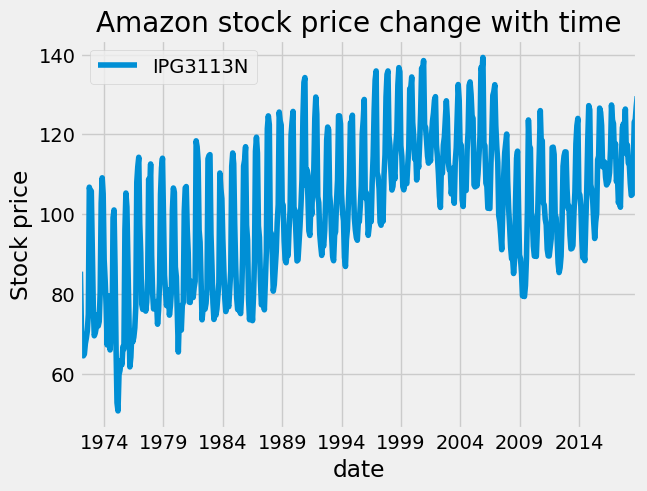

In [9]:
amazon = pd.read_csv('/kaggle/input/candy-production/candy_production.csv',
                     index_col='date',
                     parse_dates=True)
amazon.plot()
plt.title('Amazon stock price change with time')
plt.ylabel('Stock price')

First, we will apply the Adfuller-Dickey test to know whether the time series is stationary or not.

In [10]:
from statsmodels.tsa.stattools import adfuller

# Run Dicky-Fuller test
result = adfuller(amazon)

# Print test statistic
print('The test stastics:', result[0])

# Print p-value
print("The p-value:",result[1])

The test stastics: -1.7760153075016134
The p-value: 0.3924327500713988


The p-value is bigger than 0.05, therefore we cannot reject the null hypothesis and the time series is considered to be non-stationary. Therefore we will take the first difference and check whether this will make it stationary or not using also Adfuller-Dickey test.



In [11]:
# take the first diff
amazon_diff = amazon.diff()
amazon_diff.dropna(inplace=True)

# Run Dicky-Fuller test
result = adfuller(amazon_diff)

# Print test statistic
print('The test stastics:', result[0])

# Print p-value
print("The p-value:",result[1])


The test stastics: -6.175912489755701
The p-value: 6.631549159334048e-08


The p-value after taking the first difference of the amazon stock price time series is less than 0.05, so we can reject the null hypothesis and the data now is considered stationary. For the modeling step, we can follow one of the two paths mentioned above. First, use the ARMA model and apply it to the data with the first difference. Then the **np.cumsum** function will be used for the prediction of the actual data not the data with the difference.

In [12]:
from statsmodels.tsa.arima.model import ARIMA
# Instantiate model object
model = ARIMA(amazon_diff, order=(1,0,1))
# Fit model
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               IPG3113N   No. Observations:                  563
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2011.760
Date:                Sat, 02 Sep 2023   AIC                           4031.521
Time:                        11:08:32   BIC                           4048.854
Sample:                    02-01-1972   HQIC                          4038.287
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0742      0.566      0.131      0.896      -1.035       1.183
ar.L1          0.3535      0.204      1.736      0.083      -0.046       0.753
ma.L1         -0.0976      0.215     -0.455      0.6

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


The second method is to use the ARIMA model and use the actual data and use the difference parameter in the ARIMA function.

In [13]:
from statsmodels.tsa.arima.model import ARIMA
# Instantiate model object
model = ARIMA(amazon, order=(1,1,1))
# Fit model
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               IPG3113N   No. Observations:                  564
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2011.770
Date:                Sat, 02 Sep 2023   AIC                           4029.540
Time:                        11:08:32   BIC                           4042.540
Sample:                    01-01-1972   HQIC                          4034.615
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3536      0.185      1.910      0.056      -0.009       0.716
ma.L1         -0.0977      0.200     -0.489      0.625      -0.489       0.294
sigma2        74.3361      3.099     23.984      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In part 2 of this notebook, we will discuss how to choose the best model parameter using the autocorrelation function (ACF) and partial autocorrelation function (PACF) plot and using the Akaike information criterion (AIC) and Bayesian Information Criteria (BIC) to narrow down our choices. After that, we will discuss the Box-Jenkins method which will help you to go from raw time series to a model ready for production. Then we will discuss how to apply this to seasonal time series.
